In [1]:
import sys
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from generate_chunks import load_data
from train_models import ModelTrainer
from failure_detection import detect_failures, failure_list_to_interval, print_failures, collate_intervals, extreme_anomaly, simple_lowpass_filter

model_name = 'TCN'
model = ModelTrainer(f'configs/{model_name}.json').fit()
train_chunks, training_chunk_dates, test_chunks, test_chunk_dates = load_data(version=model.version, scaler=model.scaler)

0.003299389570020134
[2022-06-04 09:03:26.234000, 2022-06-04 17:28:56.958000]
[2022-07-11 08:52:37.710000, 2022-07-14 13:29:50.352000]


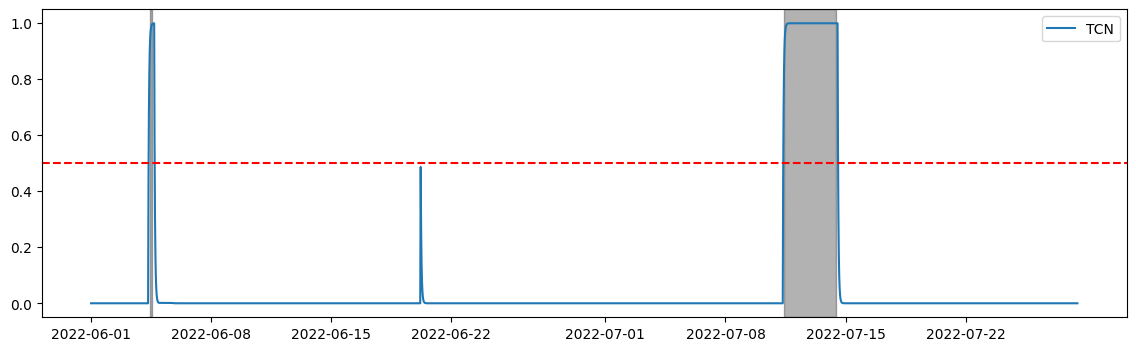

In [15]:

feature_names = ['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Oil_temperature', 'Flowmeter', 'Motor_current', 'COMP']

plt.figure(figsize=(14, 4))

actual_failures = [
    (np.datetime64('2022-06-04T10:19:24'), np.datetime64('2022-06-04T14:22:39')),
    (np.datetime64('2022-07-11T10:10:18'), np.datetime64('2022-07-14T10:22:08')),
]
for (start, end) in actual_failures:
    plt.axvspan(start, end, color='black', alpha=0.3)

val_size = int(0.3 * len(train_chunks))
train_errors = model.calc_loss(train_chunks[-val_size:], train_chunks[-val_size:], average=False).mean(axis=(1,2))
#train_errors = model.calc_loss(train_chunks, train_chunks, average=False).mean(axis=(1,2))
test_errors_raw = model.calc_loss(test_chunks, test_chunks, average=False)
test_errors = test_errors_raw.mean(axis=(1,2))
# anom = extreme_anomaly(train_errors)
# anom = 0.005
# print('tau_anom', anom)


q05, q10, q25, q75, q90, q95, q97, q98, q99 = np.quantile(train_errors, [0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.97, 0.98, 0.99])
#anom = q75 + 3*(q75-q25)
anom = q99
print(anom)

binary_output = (test_errors > anom).astype(np.int8)
output = simple_lowpass_filter(binary_output, 0.08)
failures = (output > 0.5).astype(np.int8)
print_failures(test_chunk_dates, failures)
plt.plot(test_chunk_dates[:, 1], output, label=model_name)
plt.axhline(y=0.5, color='red', linestyle='--')

plt.legend()
plt.show()

(14789, 1800, 8)


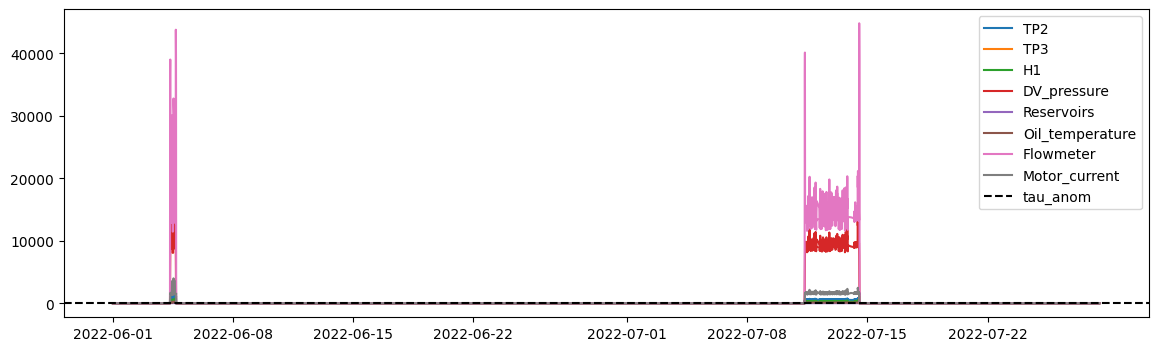

In [4]:
plt.figure(figsize=(14, 4))
print(test_errors_raw.shape)
for i in range(test_errors_raw.shape[2]):
    plt.plot(test_chunk_dates[:, 1], test_errors_raw[..., i].mean(axis=-1), label=feature_names[i])

#plt.xlim(np.datetime64('2022-06-08T00:00:00'), np.datetime64('2022-06-10T20:00:00'))
#plt.ylim(0, anom*3/2)
plt.axhline(y=anom, linestyle='--', color='black', label='tau_anom')
plt.legend()
plt.show()

(14789, 1800, 8)


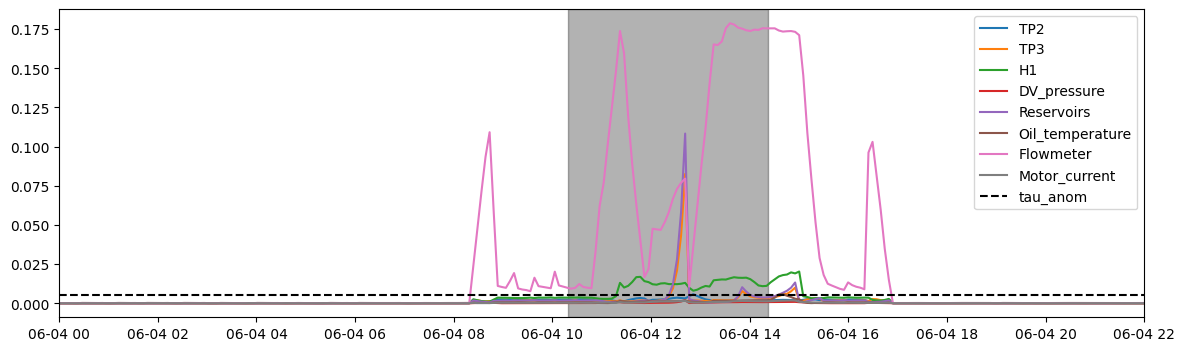

In [33]:
plt.figure(figsize=(14, 4))
print(test_errors_raw.shape)
for i in range(test_errors_raw.shape[2]):
    plt.plot(test_chunk_dates[:, 1], test_errors_raw[..., i].mean(axis=-1), label=feature_names[i])

plt.xlim(np.datetime64('2022-06-04T00:00:00'), np.datetime64('2022-06-04T22:00:00'))
plt.axvspan(actual_failures[0][0], actual_failures[0][1], color='black', alpha=0.3)
plt.axhline(y=0.005, linestyle='--', color='black', label='tau_anom')
plt.legend()
plt.show()

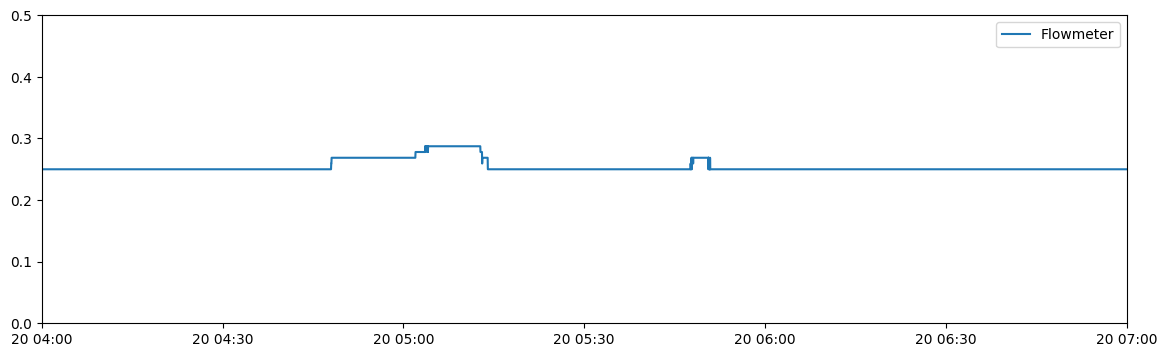

In [37]:
final_metro = pd.read_csv(f'MetroPT2.csv')
final_metro['timestamp'] = pd.to_datetime(final_metro['timestamp'])
final_metro = final_metro.sort_values('timestamp')
final_metro.reset_index(drop=True, inplace=True)

plt.figure(figsize=(14, 4))
plt.plot(final_metro.timestamp, final_metro.Flowmeter, label='Flowmeter')
plt.xlim(np.datetime64('2022-06-20T04:00:00'), np.datetime64('2022-06-20T07:00:00'))
plt.ylim(0, 0.5)
plt.legend()
plt.show()
